In [1]:
# Import all of the libraries that we will need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from matplotlib.ticker import MaxNLocator

# put the two csv files into two distinct dataframes
df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

# excluding the years that the league had less than 32 teams
excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
# dropping redundant values that could influence our results 
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)

# this will allow us to merge the datasets
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']
to_scale = ['year', 'week', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

In [2]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']

# 80/20 split for training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [3]:
scaled_dfs_train = []
scaled_dfs_test = []
for col in to_scale:
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train[[col]])
    scaled_test = scaler.transform(X_test[[col]])
    scaled_dfs_train.append(pd.DataFrame(scaled_train, columns=scaler.get_feature_names_out([col])))
    scaled_dfs_test.append(pd.DataFrame(scaled_test, columns=scaler.get_feature_names_out([col])))

X_train_scaled = pd.concat([X_train.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_train, axis=1)
X_test_scaled = pd.concat([X_test.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_test, axis=1)

In [4]:
#converting our categorical data into 1s and 0s
# for the purposes of One-Hot Encoding, considering we cannot run
# categorical data through our models
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train_scaled[[col]])
    encoded_test = encoder.transform(X_test_scaled[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)

In [5]:
tuned_model = KNeighborsRegressor()

In [6]:
param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [5, 10, 15, 20, 25, 30],
    'p': [1, 2]
}

In [7]:
scorer = make_scorer(r2_score, greater_is_better=True)

In [8]:
grid_search = GridSearchCV(tuned_model, param_grid, scoring=scorer, cv=3)
grid_result = grid_search.fit(X_train_encoded, y_train) # enter our X and Y values here

In [9]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}


In [10]:
# we predict our values here using the test data
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# in a nutshell, mse and mae should ideally be close to zero
# if not, then we have a significant amount of error the larger it gets
#Our R2 score should ideally be close to 1, meaning that our model is fairly accurate
r2_score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error: ", mae)
print("R2 Score: ", r2_score)

Mean Squared Error: 51948395.61325686
Mean Absolute Error:  4600.222323569869
R2 Score:  0.3626578023046637


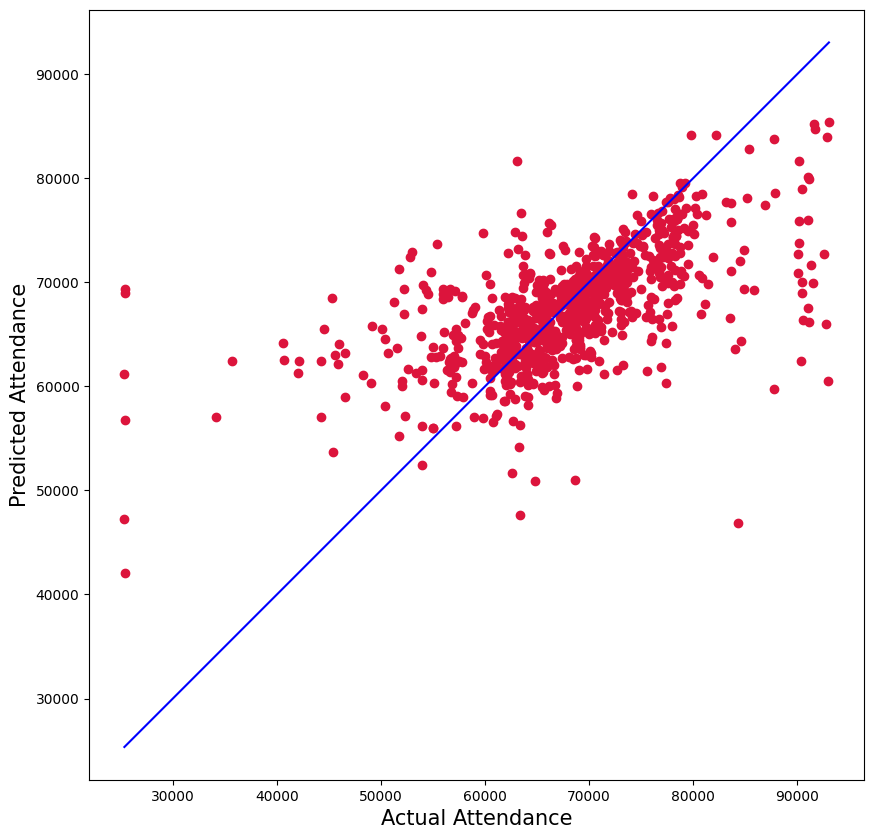

In [11]:
# Here, we print a scatter plot that shows us how our model performed
# the closer to the line, the more the model had accurately guessed the attendance
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.axis('equal')
plt.show()